<font size=8><center> Real Time Object Detection for Sign Language with Yolov8</font></br>
<font size=7> Part 1 - EDA

<center><img src="https://www.softwareone.com/-/media/global/social-media-and-blog/hero/implementing-artificial-intelligence-part-1-hero.jpg?rev=56ebf75efd06466786861433a1cae008&sc_lang=es-es&hash=156019D8878E348531B101651625C76A" width=900>

# 1. Setup

In [ ]:
import matplotlib.pyplot as plt
import cv2
import json
import random
import numpy as np
import os
import pandas as pd
from PIL import Image
import time
import shutil
import sklearn.model_selection as model_selection

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="49HHNp5vJ1N3kidpMb2T")
project = rf.workspace("capstone-project-uukuv").project("sign_language-vly5n")
dataset = project.version(1).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Sign_Language-1 in coco:: 100%|██████████| 728/728 [00:03<00:00, 225.38it/s]


In [ ]:
# Create annotations paths
train = "/content/Sign_Language-1/train/"
test = "/content/Sign_Language-1/test/"
valid = "/content/Sign_Language-1/valid/"

train_annot = "/content/Sign_Language-1/train/_annotations.coco.json"
test_annot = "/content/Sign_Language-1/test/_annotations.coco.json"
valid_annot = "/content/Sign_Language-1/valid/_annotations.coco.json"

# 2. Visualize

In [ ]:
# Create a function to vizualize randomly 5 images from the dataset

def visualize(path):
  # Load the dataset
  with open(path) as f:
      data = json.load(f)

  # Select the number of images you want to visualize
  num_images = 5

  # Create a list of image ids to select from
  image_ids = [image["id"] for image in data["images"]]

  # Randomly select the image ids
  random_image_ids = random.sample(image_ids, num_images)

  # Iterate through the selected number of images
  for image_id in random_image_ids:
      # Get the image file path
      img_path = [image["file_name"] for image in data["images"] if image["id"] == image_id][0]
      # Load the image
      img = cv2.imread(img_path)
      # Get the annotations for the image
      annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
      # Iterate through each annotation in the image
      for annotation in annotations:
          # Get the bounding box coordinates
          xmin = annotation["bbox"][0]
          ymin = annotation["bbox"][1]
          width = annotation["bbox"][2]
          height = annotation["bbox"][3]
          xmax = xmin + width
          ymax = ymin + height
          # Draw the bounding box on the image
          cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 8)
          # Add the class label to the image
          class_id = annotation["category_id"]
          class_label = data["categories"][class_id]["name"]
          cv2.putText(img, class_label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      # Display the image
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()

## 2.1 Train

/content/Sign_Language-1/train


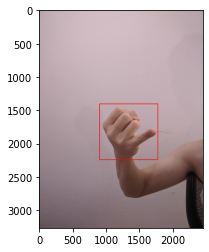

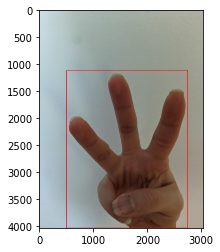

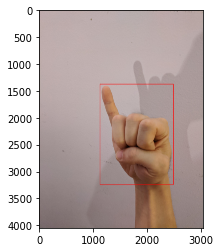

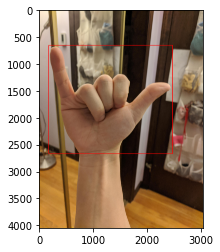

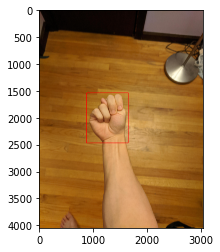

In [ ]:
%cd /content/Sign_Language-1/train
visualize(train_annot)

## 2.2 Test

/content/Sign_Language-1/test


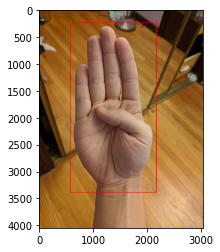

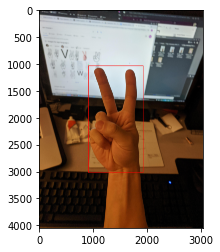

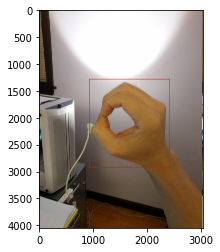

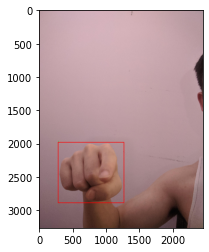

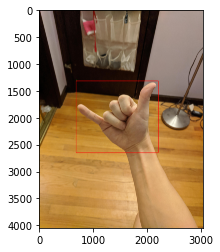

In [ ]:
%cd /content/Sign_Language-1/test
visualize(test_annot)

## 2.1 Valid

/content/Sign_Language-1/valid


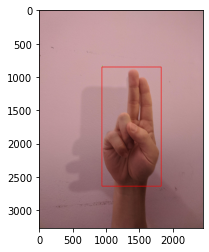

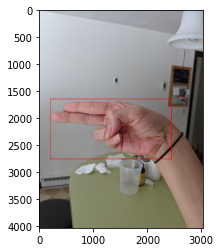

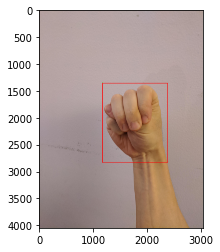

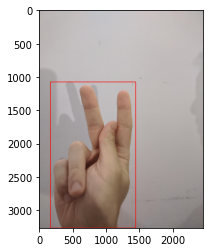

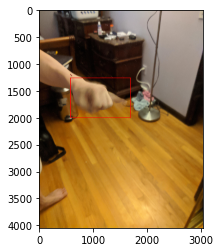

In [ ]:
%cd /content/Sign_Language-1/valid
visualize(valid_annot)

We can see that the last image was not labelled correctly meaning that labelling will need to be reviewed.

# 3. Size Distribution

In [ ]:
# Create a function to check size distribution

def size_distribution(annotations, path):
  # Load the dataset
  with open(annotations) as f:
      data = json.load(f)

  # Initialize variables for storing image properties
  widths = []
  heights = []
  aspect_ratios = []

  # Iterate through each image in the dataset
  for image in data['images']:
      # Get the image file path
      img_path = path + image["file_name"]
      # Load the image
      img = cv2.imread(img_path)
      # Get the image width and height
      height, width, _ = img.shape
      # Append the width and height to the corresponding lists
      widths.append(width)
      heights.append(height)
      # Calculate the aspect ratio
      aspect_ratios.append(float(width) / float(height))

  # Plot histograms to visualize the distribution of image properties
  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.hist(widths)
  plt.title("Distribution of Image Widths")
  plt.xlabel("Width")
  plt.ylabel("Frequency")

  plt.subplot(132)
  plt.hist(heights)
  plt.title("Distribution of Image Heights")
  plt.xlabel("Height")
  plt.ylabel("Frequency")

  plt.subplot(133)
  plt.hist(aspect_ratios)
  plt.title("Distribution of Image Aspect Ratios")
  plt.xlabel("Aspect Ratio")
  plt.ylabel("Frequency")
  plt.show()

## 3.1 Train

/content/Sign_Language-1/train


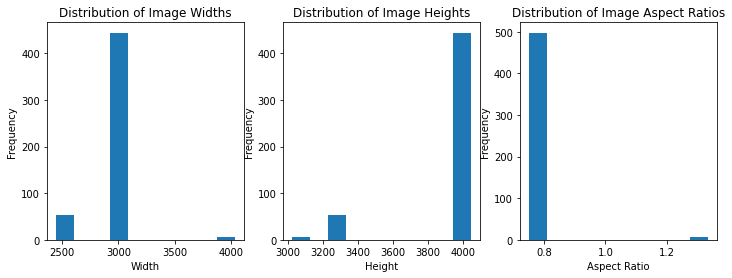

/content/Sign_Language-1/test


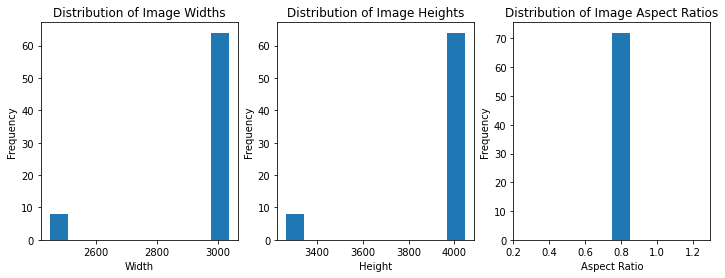

/content/Sign_Language-1/valid


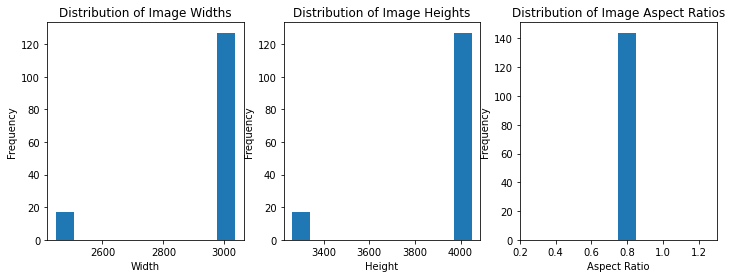

In [ ]:
%cd /content/Sign_Language-1/train
size_distribution(train_annot, train)
%cd /content/Sign_Language-1/test
size_distribution(test_annot, test)
%cd /content/Sign_Language-1/valid
size_distribution(valid_annot, valid)

# 4. Class Distribution

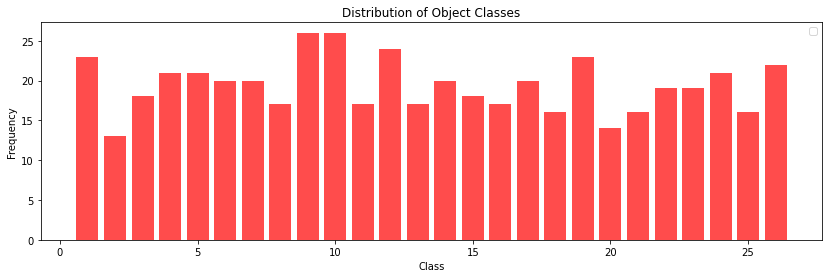

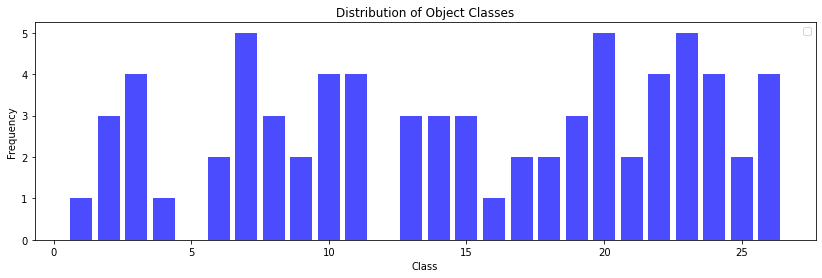

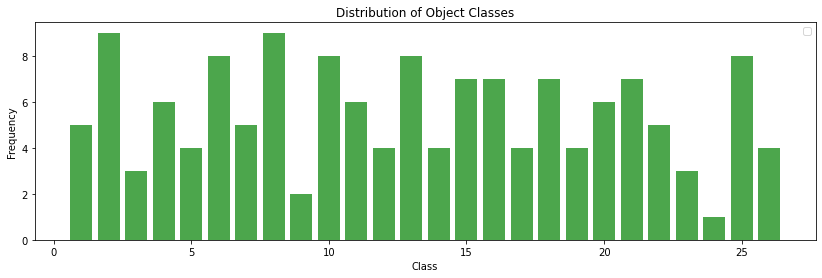

In [ ]:
def class_distribution(annotations, color):
  # Initialize variables for storing object class information
  classes = {}

  # Import annotations in json
  with open(annotations) as f:
    annotations = json.load(f)

  # Iterate through each annotation in the dataset
  for annotation in annotations["annotations"]:
      # Get the class label
      label = annotation["category_id"]
      # Check if the class has already been encountered
      if label in classes:
          # If yes, increment the count
          classes[label] += 1
      else:
          # If not, add the class to the dictionary with a count of 1
          classes[label] = 1

  # Plot a bar chart to visualize the distribution of object classes
  plt.figure(figsize=(14,4))
  plt.bar(classes.keys(), classes.values(), color=color, alpha=0.7)
  plt.title("Distribution of Object Classes")
  plt.xlabel("Class")
  plt.ylabel("Frequency")
  plt.legend()


class_distribution(train_annot, 'red')
class_distribution(test_annot, 'blue')
class_distribution(valid_annot, 'green')
plt.show()

# 5. Bounding Boxes Distribution

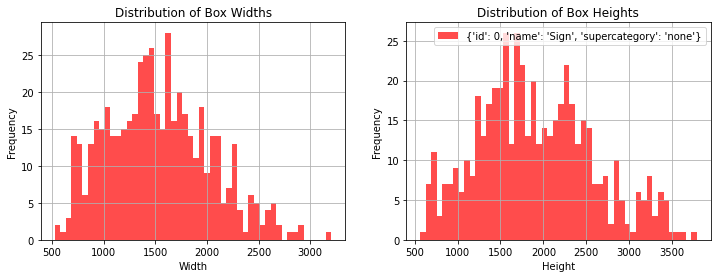

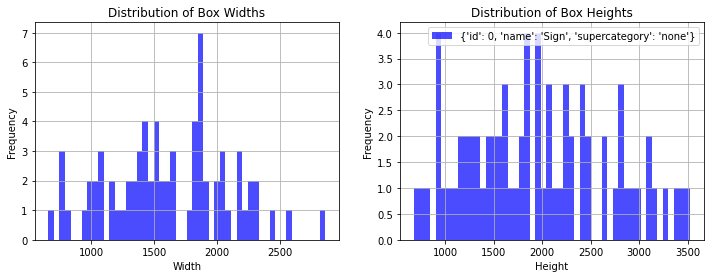

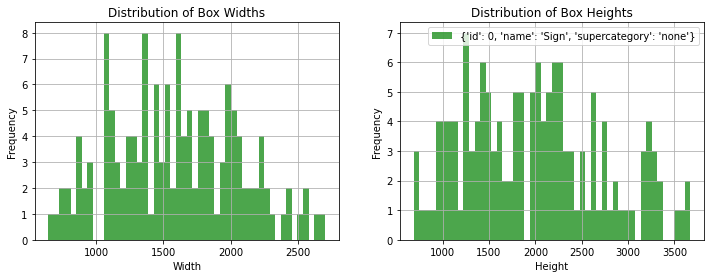

In [ ]:
def bbox_distribution(annotations, color):

  # Import annotations in json
  with open(annotations) as f:
    annotations = json.load(f)
  
  # Initialize variables for storing box properties
  box_widths = []
  box_heights = []

  # Iterate through each annotation in the dataset
  for annotation in annotations["annotations"]:
      # Get the bounding box coordinates
      xmin, ymin, width, height = annotation["bbox"]
      # Append the width and height to the corresponding lists
      box_widths.append(width)
      box_heights.append(height)

  # Plot histograms to visualize the distribution of box properties
  plt.figure(figsize=(12,4))
  plt.subplot(121)
  plt.hist(box_widths, bins=50, color=color, alpha=0.7, label=annotations["categories"])
  plt.title("Distribution of Box Widths")
  plt.xlabel("Width")
  plt.ylabel("Frequency")
  plt.grid(True)

  plt.subplot(122)
  plt.hist(box_heights, bins=50, color=color, alpha=0.7, label=annotations["categories"])
  plt.title("Distribution of Box Heights")
  plt.xlabel("Height")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.legend()

bbox_distribution(train_annot, 'red')
bbox_distribution(test_annot, 'blue')
bbox_distribution(valid_annot, 'green')
plt.show()

# 6. Pre-Processing
## 6.1 Load Data

In [ ]:
!pip install RoboFlow
# Import unsplitted data from RoboFlow
from roboflow import Roboflow
rf = Roboflow(api_key="49HHNp5vJ1N3kidpMb2T")
project = rf.workspace("capstone-project-uukuv").project("sign_language-vly5n")
dataset = project.version(2).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
loading Roboflow workspace...
loading Roboflow project...

KeyboardInterrupt: ignored

## 6.2 Resize Data 

### 6.2.1 Resizing Images (Lanczos)

In [ ]:
# Define the path to the image folder
image_path = "/content/Sign_Language-2/train"

# Define the path to save the resized images
save_path = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/resized_images"


# Define the desired height and width of the resized images
new_height = 640
new_width = 640

# Loop through all the JPG images in the folder
for file_name in os.listdir(image_path):
    if file_name.endswith(".jpg"):
        # Read the image
        image = cv2.imread(os.path.join(image_path, file_name))

        # Resize the image using Lanczos interpolation
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

        # Save the resized image
        cv2.imwrite(os.path.join(save_path, file_name), resized_image)

### 6.2.2 Resizing Bounding Boxes

1. Create a dataframe with the information/values corresponding to the key "images"

In [ ]:
# Path to the json file containing the annotations
annotation_file = "/content/Sign_Language-2/train/_annotations.coco.json"


# Load the annotations file
with open(annotation_file, "r") as f:
    annotations = json.load(f)
    
images = annotations["images"]

# Create the dataframe
df_images = pd.DataFrame(images)

# Print the dataframe
df_images.head(5)

,id,license,file_name,height,width,date_captured
0,0,1,N4_jpg.rf.b39071aad2d35c41db84f2b7b60985fc.jpg,4032,3024,2023-02-06T19:10:11+00:00
1,1,1,Z12_jpg.rf.b26c762e042e51187aecb0da5db240bf.jpg,3264,2448,2023-02-06T19:10:11+00:00
2,2,1,K19_jpg.rf.b144f6b2261c7c8ea05154d3b5f5d6f5.jpg,3264,2448,2023-02-06T19:10:11+00:00
3,3,1,K10_jpg.rf.b3e45fd911652ac705b2f35a37c41b02.jpg,4032,3024,2023-02-06T19:10:11+00:00
4,4,1,Q23_jpg.rf.b2a015ac62c9525d85d459df2b7fdcad.jpg,4048,3036,2023-02-06T19:10:11+00:00


2. Create a dataframe with the information/values corresponding to the key "annotations"

In [ ]:
annotations = annotations["annotations"]

# Create the dataframe
df_annotations = pd.DataFrame(annotations)

# Print the dataframe
df_annotations.head(5)

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,14,"[382, 1213, 1501, 2130]",3197130,[],0
1,1,1,26,"[1, 1787, 911, 923]",840853,[],0
2,2,2,11,"[318, 946, 812, 1442]",1170904,[],0
3,3,3,11,"[826, 1186, 1024, 2158]",2209792,[],0
4,4,4,17,"[694, 1841, 1851, 1758]",3254058,[],0


The bbox column contains lists with 4 values corresponding to:
- xmin: The minimum x-coordinate of the bounding box, i.e., the leftmost pixel of the bounding box.
- ymin: The minimum y-coordinate of the bounding box, i.e., the topmost pixel of the bounding box.
- height: The height of the bounding box
- width: The width of the bounding box</br></br>

3. Break down the bbox column

In [ ]:
# Split the bbox into separate columns
df_annotations[['xmin', 'ymin', 'w', 'h']] = pd.DataFrame(df_annotations['bbox'].to_list(), index=df_annotations.index)

# Drop the bbox column
df_annotations.drop('bbox', axis=1, inplace=True)

df_annotations.head(5)

,id,image_id,category_id,area,segmentation,iscrowd,xmin,ymin,w,h
0,0,0,14,3197130,[],0,382,1213,1501,2130
1,1,1,26,840853,[],0,1,1787,911,923
2,2,2,11,1170904,[],0,318,946,812,1442
3,3,3,11,2209792,[],0,826,1186,1024,2158
4,4,4,17,3254058,[],0,694,1841,1851,1758


4. Merge the two tables using the id columns of df_images as a primary key

In [ ]:
# Rename the 'id' column in the annotations dataframe to avoid having two columns with the same name
df_annotations = df_annotations.rename(columns={'id': 'annotation_id'})

# Merge the two dataframes on the 'id' and 'image_id' columns
df_merge = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id')

df_merge.head(5)

,id,license,file_name,height,width,date_captured,annotation_id,image_id,category_id,area,segmentation,iscrowd,xmin,ymin,w,h
0,0,1,N4_jpg.rf.b39071aad2d35c41db84f2b7b60985fc.jpg,4032,3024,2023-02-06T19:10:11+00:00,0,0,14,3197130,[],0,382,1213,1501,2130
1,1,1,Z12_jpg.rf.b26c762e042e51187aecb0da5db240bf.jpg,3264,2448,2023-02-06T19:10:11+00:00,1,1,26,840853,[],0,1,1787,911,923
2,2,1,K19_jpg.rf.b144f6b2261c7c8ea05154d3b5f5d6f5.jpg,3264,2448,2023-02-06T19:10:11+00:00,2,2,11,1170904,[],0,318,946,812,1442
3,3,1,K10_jpg.rf.b3e45fd911652ac705b2f35a37c41b02.jpg,4032,3024,2023-02-06T19:10:11+00:00,3,3,11,2209792,[],0,826,1186,1024,2158
4,4,1,Q23_jpg.rf.b2a015ac62c9525d85d459df2b7fdcad.jpg,4048,3036,2023-02-06T19:10:11+00:00,4,4,17,3254058,[],0,694,1841,1851,1758


5. Scale the bounding boxes coordinates

In [ ]:
# Define the new image dimensions
new_width = 640
new_height = 640

# Scale the bounding box coordinates
df_merge['xmin'] = df_merge['xmin'] / df_merge['width'] * new_width
df_merge['ymin'] = df_merge['ymin'] / df_merge['height'] * new_height
df_merge['w'] = df_merge['w'] / df_merge['width'] * new_width
df_merge['h'] = df_merge['h'] / df_merge['height'] * new_height

# Scale the area
df_merge['area'] = df_merge['area'] / (df_merge['width'] * df_merge['height']) * (new_width * new_height)

# Drop the original image dimensions columns
df_merge.drop(['width', 'height'], axis=1, inplace=True)

# Recreate 2 columns width and height with = 640
df_merge['width'] = 640
df_merge['height'] = 640

df_merge.head(5)

,id,license,file_name,date_captured,annotation_id,image_id,category_id,area,segmentation,iscrowd,xmin,ymin,w,h,width,height
0,0,1,N4_jpg.rf.b39071aad2d35c41db84f2b7b60985fc.jpg,2023-02-06T19:10:11+00:00,0,0,14,107403.376165,[],0,80.846561,192.539683,317.671958,338.095238,640,640
1,1,1,Z12_jpg.rf.b26c762e042e51187aecb0da5db240bf.jpg,2023-02-06T19:10:11+00:00,1,1,26,43104.088171,[],0,0.261438,350.392157,238.169935,180.980392,640,640
2,2,1,K19_jpg.rf.b144f6b2261c7c8ea05154d3b5f5d6f5.jpg,2023-02-06T19:10:11+00:00,2,2,11,60023.273100,[],0,83.137255,185.490196,212.287582,282.745098,640,640
3,3,1,K10_jpg.rf.b3e45fd911652ac705b2f35a37c41b02.jpg,2023-02-06T19:10:11+00:00,3,3,11,74235.055010,[],0,174.814815,188.253968,216.719577,342.539683,640,640
4,4,1,Q23_jpg.rf.b2a015ac62c9525d85d459df2b7fdcad.jpg,2023-02-06T19:10:11+00:00,4,4,17,108453.348748,[],0,146.297760,291.067194,390.197628,277.944664,640,640


6. Check results

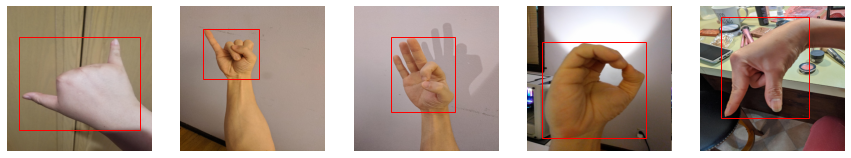

In [ ]:
def visualize_images(df_merge, image_path):
    num_images = 5
    fig, axs = plt.subplots(1, num_images, figsize=(15,15))
    for i in range(num_images):
        # randomly select an image
        random_index = random.randint(0, df_merge.shape[0]-1)
        random_row = df_merge.iloc[random_index]

        # read the image
        image = cv2.imread(f'{image_path}/{random_row["file_name"]}')

        # plot the image
        axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')

        # plot the bounding box
        xmin, ymin = random_row["xmin"], random_row["ymin"]
        height, width = random_row["h"], random_row["w"]
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, color='red')
        axs[i].add_patch(rect)

    plt.show()


resized_images = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/resized_images"

# call the function
visualize_images(df_merge, resized_images)

7. Update the json annotation file 

We will resplit df_merge into two tables with the exact same structure as the json file to update it 

In [ ]:
# Create a new table with the updated images annotations
df_images_resized = df_merge[df_images.columns.tolist()]
df_images_resized.head(5)

,id,license,file_name,height,width,date_captured
0,0,1,N4_jpg.rf.b39071aad2d35c41db84f2b7b60985fc.jpg,640,640,2023-02-06T19:10:11+00:00
1,1,1,Z12_jpg.rf.b26c762e042e51187aecb0da5db240bf.jpg,640,640,2023-02-06T19:10:11+00:00
2,2,1,K19_jpg.rf.b144f6b2261c7c8ea05154d3b5f5d6f5.jpg,640,640,2023-02-06T19:10:11+00:00
3,3,1,K10_jpg.rf.b3e45fd911652ac705b2f35a37c41b02.jpg,640,640,2023-02-06T19:10:11+00:00
4,4,1,Q23_jpg.rf.b2a015ac62c9525d85d459df2b7fdcad.jpg,640,640,2023-02-06T19:10:11+00:00


In [ ]:
# Create a new table with the updated annotations
df_annotations_resized = df_merge[df_annotations.columns.tolist()]

# Round up the numbers to avoid error during training
df_annotations_resized["xmin"] = df_annotations_resized["xmin"].astype(int)
df_annotations_resized["ymin"] = df_annotations_resized["ymin"].astype(int)
df_annotations_resized["h"] = df_annotations_resized["h"].astype(int)
df_annotations_resized["w"] = df_annotations_resized["w"].astype(int)
df_annotations_resized["area"] = df_annotations_resized["area"].astype(int)

# recreate the bbox columns
df_annotations_resized['bbox'] = df_annotations_resized.apply(lambda x: [x['xmin'], x['ymin'], x['w'], x['h']], axis=1)

# drop the original columns
df_annotations_resized.drop(['xmin', 'ymin', 'h', 'w'], axis=1, inplace=True)

# change back column name annotations_id to id
df_annotations_resized.rename(columns={"annotation_id": "id"}, inplace=True)
df_annotations_resized.head(5)

# Put back bbox column in the fourth position
  # Define the new order of columns
columns = ['id','image_id', 'category_id', 'bbox', "segmentation", "iscrowd"]
  # Reindex the DataFrame with the new column order
df_annotations_resized = df_annotations_resized.reindex(columns=columns)

df_annotations_resized.head(5)

,id,image_id,category_id,bbox,segmentation,iscrowd
0,0,0,14,"[80, 192, 338, 338]",[],0
1,1,1,26,"[0, 350, 180, 180]",[],0
2,2,2,11,"[83, 185, 282, 282]",[],0
3,3,3,11,"[174, 188, 342, 342]",[],0
4,4,4,17,"[146, 291, 277, 277]",[],0


In [ ]:
# Update the json file

# Load the annotations file
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Update the annotations["images"] part
for i, row in df_images_resized.iterrows():
    for image in annotations["images"]:
        if image["id"] == row["id"]:
            image["height"] = row["height"]
            image["width"] = row["width"]

# Write the updated annotations back to the file
with open(annotation_file, "w") as f:
    json.dump(annotations, f)

In [ ]:
# Load the annotations file
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Update the annotations["annotations"] part
for i, row in df_annotations_resized.iterrows():
    for ann in annotations["annotations"]:
        if ann["id"] == row["id"]:
            ann["image_id"] = row["image_id"]
            ann["category_id"] = row["category_id"]
            ann["bbox"] = row["bbox"]
            ann["segmentation"] = row["segmentation"]
            ann["iscrowd"] = row["iscrowd"]

# Write the updated annotations back to the file
with open(annotation_file, "w") as f:
    json.dump(annotations, f)

## 6.3 Split the data
### 6.3.1 Annotations

In [ ]:
# Define path to json file
annotation_file="/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/resized_images/_annotations.coco.json"

# Load the annotations file
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Extract the annotations information into a dataframe
df = pd.DataFrame(annotations["annotations"])

df.head(5)

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,14,"[80, 192, 338, 338]",3197130,[],0
1,1,1,26,"[0, 350, 180, 180]",840853,[],0
2,2,2,11,"[83, 185, 282, 282]",1170904,[],0
3,3,3,11,"[174, 188, 342, 342]",2209792,[],0
4,4,4,17,"[146, 291, 277, 277]",3254058,[],0


In [ ]:
# Group the annotations by class_id
grouped = df.groupby(['category_id'])

# Create a list of image ids for each group
grouped_image_ids = [group[1]['image_id'].tolist() for group in grouped]

# Check the number of element per sublist
grouped_image_ids_lengths = list(map(len, grouped_image_ids))
len(grouped_image_ids_lengths)

26

After few unfruitful attempts with sklearn, I decided that the fastest and most secured way would be to do the split myself manually

In [ ]:
train_image_ids = [grouped_image_ids[0][:21], 
                   grouped_image_ids[1][:17], 
                   grouped_image_ids[2][:17],
                   grouped_image_ids[3][:20], 
                   grouped_image_ids[4][:17], 
                   grouped_image_ids[5][:22], 
                   grouped_image_ids[6][:22], 
                   grouped_image_ids[7][:21], 
                   grouped_image_ids[8][:22], 
                   grouped_image_ids[9][:26], 
                   grouped_image_ids[10][:19], 
                   grouped_image_ids[11][:20], 
                   grouped_image_ids[12][:20], 
                   grouped_image_ids[13][:19], 
                   grouped_image_ids[14][:20], 
                   grouped_image_ids[15][:17], 
                   grouped_image_ids[16][:18], 
                   grouped_image_ids[17][:17], 
                   grouped_image_ids[18][:22], 
                   grouped_image_ids[19][:17], 
                   grouped_image_ids[20][:17], 
                   grouped_image_ids[21][:20], 
                   grouped_image_ids[22][:19], 
                   grouped_image_ids[23][:18], 
                   grouped_image_ids[24][:18], 
                   grouped_image_ids[25][:22]]

In [ ]:
test_image_ids = [grouped_image_ids[0][21: 26], 
                   grouped_image_ids[1][17: 22], 
                   grouped_image_ids[2][17: 22],
                   grouped_image_ids[3][20: 25], 
                   grouped_image_ids[4][17: 21], 
                   grouped_image_ids[5][22: 26], 
                   grouped_image_ids[6][22: 26], 
                   grouped_image_ids[7][21: 25], 
                   grouped_image_ids[8][22: 26], 
                   grouped_image_ids[9][26: 30], 
                   grouped_image_ids[10][19: 23], 
                   grouped_image_ids[11][20: 24], 
                   grouped_image_ids[12][20: 24], 
                   grouped_image_ids[13][19: 23], 
                   grouped_image_ids[14][20: 24], 
                   grouped_image_ids[15][17: 21], 
                   grouped_image_ids[16][18: 22], 
                   grouped_image_ids[17][17: 21], 
                   grouped_image_ids[18][22: 26], 
                   grouped_image_ids[19][17: 21], 
                   grouped_image_ids[20][17: 21], 
                   grouped_image_ids[21][20: 24], 
                   grouped_image_ids[22][19: 23], 
                   grouped_image_ids[23][18: 22], 
                   grouped_image_ids[24][18: 22], 
                   grouped_image_ids[25][22: 26]]

In [ ]:
val_image_ids = [grouped_image_ids[0][26:], 
                   grouped_image_ids[1][22:], 
                   grouped_image_ids[2][22:],
                   grouped_image_ids[3][25:], 
                   grouped_image_ids[4][21:], 
                   grouped_image_ids[5][26:], 
                   grouped_image_ids[6][26:], 
                   grouped_image_ids[7][25:], 
                   grouped_image_ids[8][26:], 
                   grouped_image_ids[9][30:], 
                   grouped_image_ids[10][23:], 
                   grouped_image_ids[11][24:], 
                   grouped_image_ids[12][24:], 
                   grouped_image_ids[13][23:], 
                   grouped_image_ids[14][24:], 
                   grouped_image_ids[15][21:], 
                   grouped_image_ids[16][22:], 
                   grouped_image_ids[17][21:], 
                   grouped_image_ids[18][26:], 
                   grouped_image_ids[19][21:], 
                   grouped_image_ids[20][21:], 
                   grouped_image_ids[21][24:], 
                   grouped_image_ids[22][23:], 
                   grouped_image_ids[23][22:], 
                   grouped_image_ids[24][22:], 
                   grouped_image_ids[25][26:]]

In [ ]:
# Define a function to concatenate the lists
def concat_list(concatenated_list, image_ids):
  for sublist in image_ids:
    for item in sublist:
      concatenated_list.append(item)

# create empty lists for the values
train_ids = []
test_ids = []
val_ids = []

# Call the function
concat_list(train_ids, train_image_ids)
concat_list(test_ids, test_image_ids)
concat_list(val_ids, val_image_ids)

In [ ]:
# Check len of each list
print(len(train_ids))
print(len(test_ids))
print(len(val_ids))
print(len(train_ids) + len(test_ids) + len(val_ids))
print(df["image_id"].count())

508
108
104
720
720


In [ ]:
# Check if there is any common element in each list
result = set(train_ids) & set(test_ids) & set(val_ids)

print(list(result))

[]


I have created 3 copies of my annotations.json file for each split and will use the lists with image_ids I created to filter it

In [ ]:
# Define a function to filter the json files

def filter_annotations_and_images(file_path, mylist):
    # Load the annotations file
    with open(file_path, "r") as f:
        annotations = json.load(f)

    # Filter the annotations
    filtered_annotations = [ann for ann in annotations["annotations"] if ann["image_id"] in mylist]

    # Filter the images
    filtered_images = [img for img in annotations["images"] if img["id"] in mylist]

    # Update the annotations and images in the file
    annotations["annotations"] = filtered_annotations
    annotations["images"] = filtered_images

    # Save the updated annotations and images back to the same file
    with open(file_path, "w") as f:
        json.dump(annotations, f, indent=2)

# Define the path to my json files
train_annotations = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/train/train_annotations.coco.json"
test_annotations = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/test/test_annotations.coco.json"
val_annotations = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/val/val_annotations.coco.json"

# call the function train
filter_annotations_and_images(train_annotations, train_ids)
# Call the function for test
filter_annotations_and_images(test_annotations, test_ids)
# Call the function for val
filter_annotations_and_images(val_annotations, val_ids)

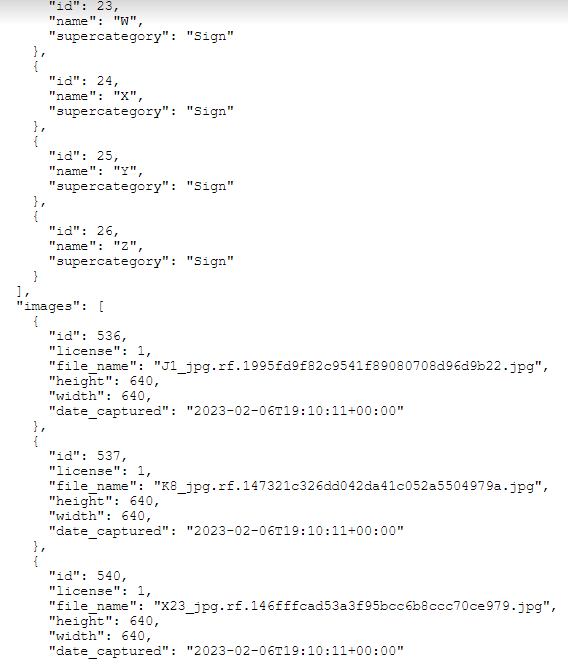

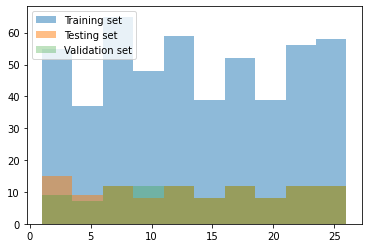

<Figure size 1440x864 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(annotations_file):
    with open(annotations_file, "r") as f:
        annotations = json.load(f)
    return [ann["category_id"] for ann in annotations["annotations"]]

# Plot the histogram for each set of annotations
train_hist = plot_class_distribution(train_annotations)
test_hist = plot_class_distribution(test_annotations)
val_hist = plot_class_distribution(val_annotations)

plt.hist(train_hist, alpha=0.5, label="Training set")
plt.hist(test_hist, alpha=0.5, label="Testing set")
plt.hist(val_hist, alpha=0.3, label="Validation set")

# Add a legend
plt.legend()

plt.figure(figsize=(20,12))

# Show the plot
plt.show()

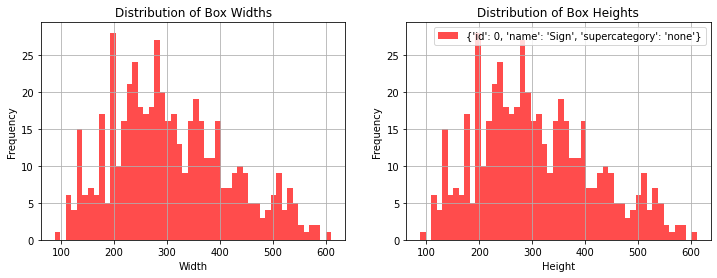

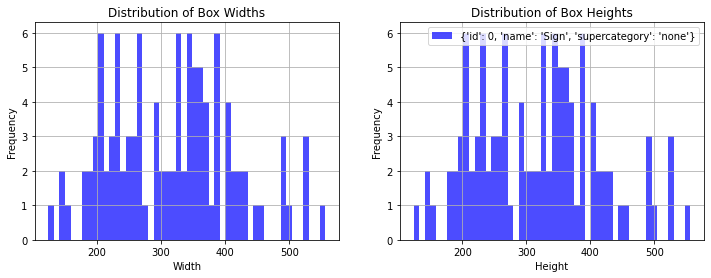

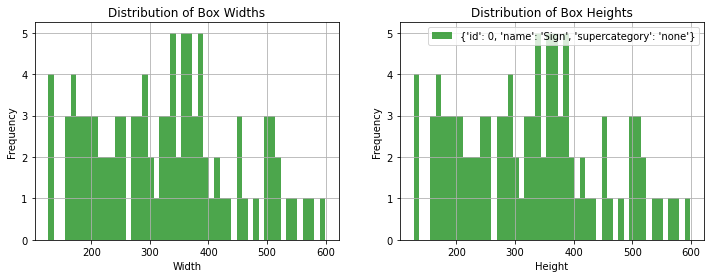

In [ ]:
train_annotation = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/Data/Split_data/train/train_annotations.coco.json" 
test_annotation = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/Data/Split_data/test/test_annotations.coco.json"
valid_annotation = "/content/drive/MyDrive/Deep_Learning_-_Group_Assigment/Data/Split_data/val/val_annotations.coco.json"

def bbox_distribution(annotations, color):

  # Import annotations in json
  with open(annotations) as f:
    annotations = json.load(f)
  
  # Initialize variables for storing box properties
  box_widths = []
  box_heights = []

  # Iterate through each annotation in the dataset
  for annotation in annotations["annotations"]:
      # Get the bounding box coordinates
      xmin, ymin, width, height = annotation["bbox"]
      # Append the width and height to the corresponding lists
      box_widths.append(width)
      box_heights.append(height)

  # Plot histograms to visualize the distribution of box properties
  plt.figure(figsize=(12,4))
  plt.subplot(121)
  plt.hist(box_widths, bins=50, color=color, alpha=0.7, label=annotations["categories"])
  plt.title("Distribution of Box Widths")
  plt.xlabel("Width")
  plt.ylabel("Frequency")
  plt.grid(True)

  plt.subplot(122)
  plt.hist(box_heights, bins=50, color=color, alpha=0.7, label=annotations["categories"])
  plt.title("Distribution of Box Heights")
  plt.xlabel("Height")
  plt.ylabel("Frequency")
  plt.grid(True)
  plt.legend()

bbox_distribution(train_annotation, 'red')
bbox_distribution(test_annotation, 'blue')
bbox_distribution(valid_annotation, 'green')
plt.show()

### 6.3.2 Images
This part will be executed locally as colab does not make easy to manipulate the files stored in the drive with python

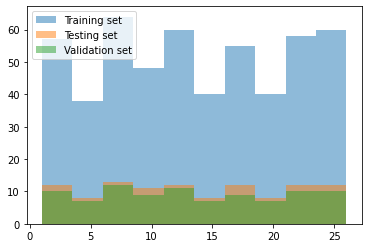

<Figure size 2880x1728 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram for each set of annotations
plt.hist(train["category_id"], alpha=0.5, label="Training set")
plt.hist(test["category_id"], alpha=0.5, label="Testing set")
plt.hist(val["category_id"], alpha=0.5, label="Validation set")

# Add a legend
plt.legend()

plt.figure(figsize=(20,12))

# Show the plot
plt.show()